In [3]:
import numpy as np
import pandas as pd

import scipy.signal as signal
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
import cmocean

from plotting import *

In [4]:
#files on disk
mask_full_file = './data/omega_upward_mask_2020_full.npy'
eof1_file = './data/eof1_all_months.npy'
eof2_file = './data/eof2_all_months.npy'

#variable files on disk
lon_file = './data/lon.npy'
lat_file = './data/lat.npy'
p_file = './data/p.npy'
time_file = './data/time.npy'

#constants
monmax = 468

In [5]:
#load files
mask_full = np.load(mask_full_file)

lon = np.load(lon_file)
lat = np.load(lat_file)
time = np.load(time_file)
time = pd.to_datetime(time)

p = np.load(p_file)
#subset pressure levels to match seasonal mask
p = p[p>=70]


#load shallow circulation and anomaly arrays
eof1 = np.load(eof1_file)
eof2 = np.load(eof2_file)

#replace NaNs with zeros for periodogram calculation/plotting method
mask_full[np.where(np.isnan(mask_full))] = 0

We already have the EOFs of our data, and used them to show which pressure levels display the most variance. Now, we want to get the Principal Components from the EOFs so that we can do a compositing analysis. To get the Principal Components from the EOFs, we are going to regress the EOFs onto our original upward $\omega$ data.

- reshape matrices to have shape (time, longitude)
- select 150W to match our previous index
- save these two time series as PC1 and PC2, use for composite analysis

In [6]:
#transpose mask to get dimensions (time x longitude, pressure)
mask_full_p = np.transpose(mask_full, (0, 2, 1))
mask_full_p_reshape = np.reshape(mask_full_p, (-1, 28))

In [7]:
#regress eof1 and eof2 onto our upward pressure velocity matrix
pc1_pre = np.matmul(mask_full_p_reshape, eof1)
pc2_pre = np.matmul(mask_full_p_reshape, eof2)

In [8]:
#reshape our PC matrices to select one longitude
pc1_lon = np.reshape(pc1_pre, (monmax, -1))
pc2_lon = np.reshape(pc2_pre, (monmax, -1))

In [9]:
#select Eastern Pacific at 150W
pc1 = pc1_lon[:, 140]
pc2 = pc2_lon[:, 140]

### Visual Inspection of PC1 and PC2

Now we can see what PC1 and PC2 look like.

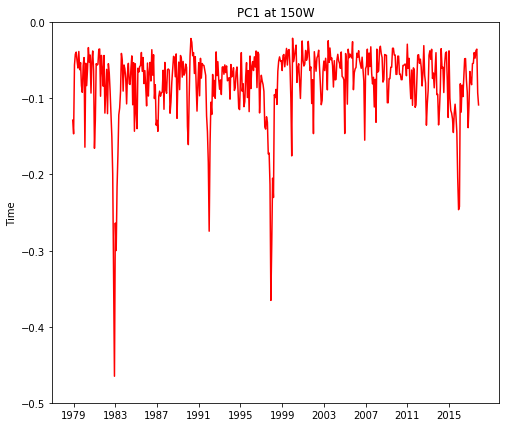

In [10]:
#plot pc1
plot_pcs(pc1, time.month, time.year, 'PC1 at 150W', [-0.5, 0.], False, -0.2)

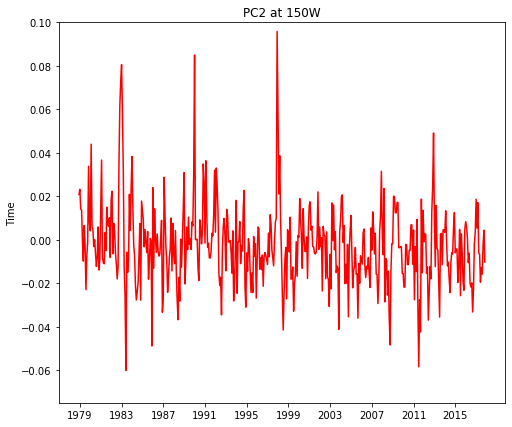

In [11]:
#plot pc2
plot_pcs(pc2, time.month, time.year, 'PC2 at 150W', [-0.075, 0.10], False, -0.02)

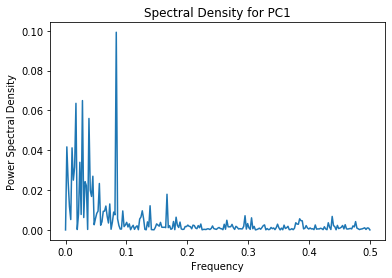

In [12]:
#plot power spectral density for pc1
f, Pxx_pc1 = signal.periodogram(pc1)
plot_periodogram(f, Pxx_pc1, 'PC1')

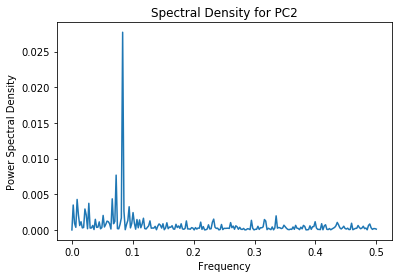

In [13]:
#plot power spectral density for pc2
f, Pxx_pc2 = signal.periodogram(pc2)
plot_periodogram(f, Pxx_pc2, 'PC2')

Like we saw in the [hovmoller.ipynb](https://github.com/Jakidxav/shallow_tropical_convection/blob/master/hovmoller.ipynb) Notebook, our data contains sub-annual information in it that did not get removed with the annual cycle related to El Niño. Because we are interested in the causes of shallow convection in the Eastern Pacific (and not necessarily the El Niño cycle in general), we are going to filter out low frequency phenomena.

### Filtering

We are going to construct a 6th order [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) so that we can highpass filter our data, and remove whatever signal was left after the annual cycle was removed. We are using a 6th order filter to ensure that we get a sharp cut at the frequencies that we are filtering for.

In [17]:
#order of the butterworth filter
NX = 6

#where to place the cut
fcut = 1/10
alpha = fcut * 2

#from scipy's webiste: numerator (b) and denominator (a) polynomials of the IIR filter
b, a = signal.butter(NX, alpha, 'highpass')

#w: The frequencies at which h was computed
#h: The frequency response, as complex numbers
w, h = signal.freqz(b, a)

#only the real parts of h
r = np.abs(h)

#amplitude
rr = np.multiply(r, r)

#period
f = w / 2.0 / np.pi

The Nyquist interval is 0-0.5 cycles per time step. We want to cut at 0.1 cycles per month (CMP) because we are trying to filter out lower frequency content closer to the 1 year mark (1/0.1 CMP = 10 months). Then we need to cut at 0.2 CPM (which is the Nyquist frequency of 0.1 CPM), and our response function should go from 0 at a frequency of 0 to 1 at frequency of 0.5 CPM, crossing sharply at 0.2 CPM.

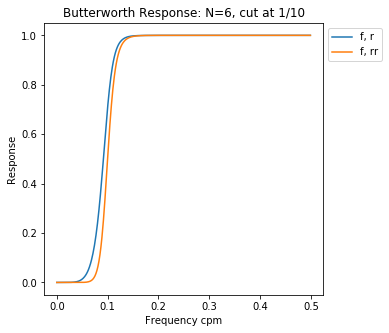

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

#plot the response function of our filter
ax.plot(f, r, label='f, r')
ax.plot(f, rr, label='f, rr')

#set x and y labels, as well as the title
ax.set_xlabel('Frequency cpm')
ax.set_ylabel('Response')
ax.set_title('Butterworth Response: N=6, cut at 1/10')

#set legend in upper right hand corner outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.show()

This looks as it should. We can now filter our PC time series.

In [19]:
#highpass filter the data
#filtfilt() centers our filtering weights to 0 phase difference
pc1_filt = signal.filtfilt(b, a, pc1)
pc2_filt = signal.filtfilt(b, a, pc2)

Let's now re-inspect our time series and their power spectral densities.

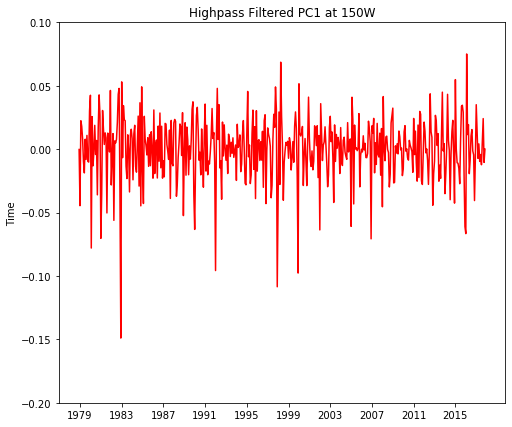

In [20]:
#plot filtered pc1
plot_pcs(pc1_filt, time.month, time.year, 'Highpass Filtered PC1 at 150W', [-0.2, 0.1], False, -0.05)

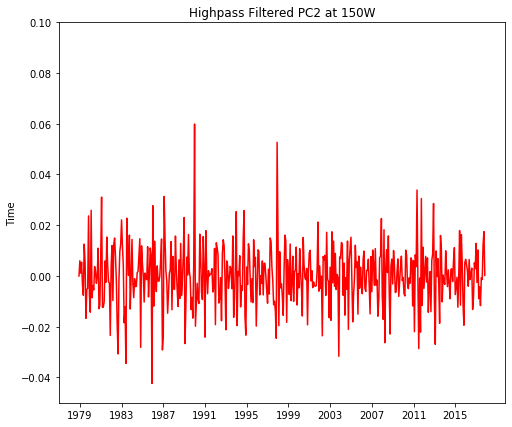

In [21]:
#plot filtered pc2
plot_pcs(pc2_filt, time.month, time.year, 'Highpass Filtered PC2 at 150W', [-0.05, 0.1], False, -0.05)

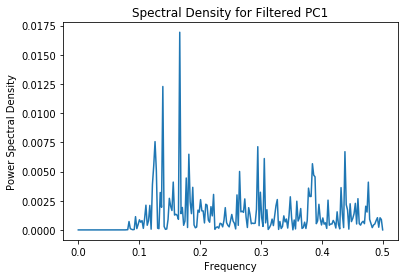

In [22]:
#plot power spectral density for filtered pc1
f, Pxx_pc1_filt = signal.periodogram(pc1_filt)
plot_periodogram(f, Pxx_pc1_filt, 'Filtered PC1')

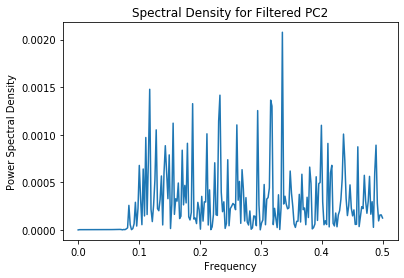

In [23]:
#plot power spectral density for filtered pc1
f, Pxx_pc2_filt = signal.periodogram(pc2_filt)
plot_periodogram(f, Pxx_pc2_filt, 'Filtered PC2')

We successfully removed the residual signal from our PC time series. This data is ready to be used for our compositing analysis, which will be explained further in the next Jupyter Notebook. In short, we are going to regress our PCs onto our anomaly data and run a t-test to see how statistically significant our new spatial structures are.